# Research on the quality of localization of movie titles

The goal of this research is to find out:
* How similar Russian titles and original titles are in general?
* Can we split dissimilar pairs (Russian title::original title) into groups by root cause?

## Importing needed packages

In [1]:
# !pip install sentence-transformers

In [2]:
import re
from pprint import PrettyPrinter
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import torch
from sentence_transformers import SentenceTransformer, util
from torch import Tensor

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style="ticks")

In [4]:
SEED = 42

## Reading data

Let's read the dataset with titles:
* `russian_title` - Russian title
* `original_title` - original title 
* `country` - country of origin

In [43]:
movie_df = pd.read_parquet(
    "../data/movies.parquet", columns=["russian_title", "original_title", "country"]
)
movie_df.shape

(984, 3)

In [44]:
movie_df.to_parquet("../data/movie_titles_countries.parquet")

In [45]:
movie_df[movie_df["country"].isin(["Япония", "Корея Южная"])].head()

,russian_title,original_title,country
15,5 сантиметров в секунду (2007),Byosoku 5 senchimetoru,Япония
55,Атака титанов. Фильм первый: Жестокий мир (2015),Shingeki no kyojin,Япония
113,"В лес, где мерцают светлячки (2011)",Hotarubi no mori e,Япония
133,Ветер крепчает (2013),Kaze tachinu,Япония
158,Воспоминания об убийстве (2003),Salinui chueok,Корея Южная


Let's remove records, where the country is in the list: 
```python 
["Япония", "Корея Южная", "Гонконг", "Китай"]
```
Because currently we cannot produce good quality embeddings for transcriptions from hieroglyphs.  
Also, let's drop the country column - we won't need it in the future analysis. 

In [46]:
filters = ["Япония", "Корея Южная", "Гонконг", "Китай"]

In [47]:
def check_countries(country, filters):
    for filter_ in filters:
        if filter_ in country:
            return False
    return True

In [49]:
movie_df = (
    movie_df.loc[movie_df["country"].apply(lambda country: check_countries(country, filters))]
    if "country" in movie_df.columns
    else movie_df
)
movie_df.drop("country", axis=1, inplace=True, errors="ignore")
movie_df.to_parquet("../data/movie_titles.parquet")

In [50]:
movie_df = pd.read_parquet("../data/movie_titles.parquet")
movie_df.shape

(877, 2)

In [51]:
movie_df = movie_df.replace(r"^\s*$", np.nan, regex=True)

In [52]:
movie_df.sample(10, random_state=SEED)

,russian_title,original_title
790,Спутник (2020),NaN
819,Тарас Бульба (2009),NaN
270,Дрянные девчонки (2004),Mean Girls
257,Дом на глубине (2021),The Deep House
320,Зверополис (2016),Zootopia
350,Иллюзия обмана (2013),Now You See Me
390,Корпорация монстров (2001),"Monsters, Inc."
912,"Хороший, плохой, злой (1966)","Il buono, il brutto, il cattivo"
309,Затерянный город (2022),The Lost City
42,Анна (2019),Anna


We can see that the `russian_title` contains the release year for every film (or at least these 10 random samples).  
This is an opportunity to clean the data.

## Cleaning the data

### Removing parenthesis from `russian_title`

#### Approach 1: Removing last 6 characters

In the previous section we've found out that the `russian_title` contains the release year of the film.  
Let's check that the last six characters from the `russian_title` is always the same and look like `(year)`.

In [12]:
six_chars = movie_df["russian_title"].apply(
    lambda s: s[-6:].replace("(", "").replace(")", "")
)
six_chars.value_counts(ascending=True).iloc[:15]

1970     1
1976     1
1959     1
 1988    1
1956     1
1975     1
 2022    1
1968     1
1939     1
1971     1
1974     1
1977     1
1989     2
1973     2
1993     2
Name: russian_title, dtype: int64

We can see that amongst the most unfrequent years there are little errors - year contains additional whitespaces.  
I'm going to check the whole title for this case.

In [13]:
indices = [i for i, year in enumerate(six_chars.values) if " " in year]
movie_df.iloc[indices]

,russian_title,original_title
705,"Привилегированные (ТВ, 2022)",Das Privileg
775,"Собачье сердце (ТВ, 1988)",NaN


Aha!

#### Approach 2: removing the whole parenthesis

Let's switch to another strategy - finding out whether every title contains substring like `(smth)` and if it is true, then remove such substring

In [14]:
def has_numbers_in_square_brackets(s):
    return bool(re.search(r"\(.*\)", s))

In [15]:
assert (
    movie_df["russian_title"].apply(has_numbers_in_square_brackets).sum()
    == movie_df.shape[0]
), "Not every title has brackets with something inside"

Every title contains some information in brackets - we don't really care what's inside them. Our goal is to clean the titles, so, we'll just delete the brackets with their contents.

In [16]:
movie_df["russian_title"] = movie_df["russian_title"].apply(
    lambda s: re.sub(r"\([^()]*\)", "", s).strip()
)
movie_df["russian_title"]

0                           1+1
1      10 причин моей ненависти
2                12 лет рабства
3                    12 обезьян
4        12 разгневанных мужчин
                 ...           
978                 Я — легенда
979                  Я — начало
980                    Я, робот
981                Яйцо Фаберже
982                      Ярость
Name: russian_title, Length: 877, dtype: object

Just checking

In [17]:
assert (
    movie_df["russian_title"].apply(has_numbers_in_square_brackets).sum() == 0
), "Not all brackets were deleted - check the procedure"

### Checking for duplicates

In [18]:
movie_df.drop_duplicates().shape == movie_df.shape

False

Let's clean the duplicates

In [19]:
movie_df.drop_duplicates(inplace=True)
assert movie_df.drop_duplicates().shape == movie_df.shape

### Checking for missing values

In [20]:
movie_df.isna().any()

russian_title     False
original_title     True
dtype: bool

We can see that the 'original_title' column contains `NaN` values.  
Probably, because not every movie has an `original_title` - maybe movie is Russian-made and doesn't have English-translated title, for example.

In [21]:
movie_df[movie_df.isnull().any(axis=1)]

,russian_title,original_title
8,1941. Крылья над Берлином,NaN
18,9 рота,NaN
41,Андрей Рублев,NaN
53,Артек. Большое путешествие,NaN
60,Бабки,NaN
...,...,...
944,Чернобыль: Зона отчуждения. Финал,NaN
969,Этерна: Часть первая,NaN
975,Я иду искать,NaN
977,Я хочу! Я буду!,NaN


Yes, my assumption was right.  
I think it is reasonable to drop such rows.

In [22]:
movie_df = (
    movie_df.dropna(axis=0, inplace=False) if movie_df.isna().any().any() else movie_df
)
movie_df.shape

(744, 2)

In [23]:
assert movie_df.isna().any().any() == False

## Semantic similarity

### Getting titles

In [24]:
russian_titles = movie_df["russian_title"].values
original_titles = movie_df["original_title"].values

### Useful functions

In [25]:
def get_embeddings(model, texts: List[str]) -> Tensor:
    texts_lowercase = list(map(str.lower, texts))
    with torch.no_grad():
        text_embeddings = model.encode(texts_lowercase, convert_to_tensor=True)
    return text_embeddings

In [26]:
def compute_embeddings(
    model, russian_titles: np.array, original_titles: np.array
) -> Tuple[Tensor]:
    russian_title_embs = get_embeddings(model, russian_titles)
    original_title_embs = get_embeddings(model, original_titles)

    return russian_title_embs, original_title_embs

In [27]:
def compute_similarity(
    russian_title_embs: Tensor, original_title_embs: Tensor
) -> Tensor:
    return util.cos_sim(russian_title_embs, original_title_embs).cpu().detach().numpy()

In [28]:
def get_similarity_dataframe(
    model, russian_titles, original_titles, sort=False, ascending=True
):
    embeddings = compute_embeddings(model, russian_titles, original_titles)
    similarity_scores = compute_similarity(*embeddings)

    rows = []
    for i in range(len(russian_titles)):
        rows.append([russian_titles[i], original_titles[i], similarity_scores[i][i]])

    similarity_df = pd.DataFrame(
        data=rows, columns=["russian_title", "original_title", "similarity"]
    )
    similarity_df["similarity"] = similarity_df["similarity"].apply(
        lambda similarity: round(similarity, 3)
    )

    del embeddings
    torch.cuda.empty_cache()

    similarity_df = (
        similarity_df.sort_values(by="similarity", ascending=ascending)
        if sort
        else similarity_df
    )

    return similarity_df

#### Debug opportunities

In [29]:
# embeddings = compute_embeddings(distil_use_v2, russian_titles, original_titles)
# similarity_scores = compute_similarity(*embeddings)

### Choosing model

We are going to use multilingual models from [SentenceTransformers](https://www.sbert.net/docs/pretrained_models.html#multi-lingual-models) framework

In [30]:
%%time

distil_use_v1 = SentenceTransformer(
    "distiluse-base-multilingual-cased-v1", cache_folder="../cache_folder"
)
distil_use_v2 = SentenceTransformer(
    "distiluse-base-multilingual-cased-v2", cache_folder="../cache_folder"
)
minilm = SentenceTransformer(
    "paraphrase-multilingual-MiniLM-L12-v2", cache_folder="../cache_folder"
)
mpnet = SentenceTransformer(
    "paraphrase-multilingual-mpnet-base-v2", cache_folder="../cache_folder"
)
labse = SentenceTransformer("LaBSE", cache_folder="../cache_folder")

CPU times: total: 22.5 s
Wall time: 52.7 s


The quality of embeddings which I've used were evaluated [here](https://habr.com/ru/post/669674/) by David Dale.  
Almost all of them are at the top average performance on sentence tasks, so for now I will limit the analysis to them.

In [31]:
models = {
    "distiluse-base-multilingual-cased-v1": distil_use_v1,
    "distiluse-base-multilingual-cased-v2": distil_use_v2,
    "paraphrase-multilingual-MiniLM-L12-v2": minilm,
    "paraphrase-multilingual-mpnet-base-v2": mpnet,
    "LaBSE": labse,
}

### Sanity check

Before moving on I'd like to check the sanity of the models - assess how well they predict the similarity between Russian and original titles

In [32]:
similarities = {}
for model_name, model in models.items():
    similarity_df = get_similarity_dataframe(model, russian_titles, original_titles)
    similarities[model_name] = similarity_df["similarity"]
    print(model_name)
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        display(similarity_df.sample(10, random_state=SEED))
    print("\n")

distiluse-base-multilingual-cased-v1


,russian_title,original_title,similarity
609,Схватка,Heat,0.501
539,Преступления будущего,Crimes of the Future,0.962
694,Чёрная Пантера,Black Panther,0.918
350,Лицо со шрамом,Scarface,0.714
174,Далласский клуб покупателей,Dallas Buyers Club,0.794
81,Бун,Boon,0.926
355,Лулу и Бриггс,Dog,0.299
424,Не смотрите наверх,Don't Look Up,0.653
523,Полынь: Дорога мёртвых,Wyrmwood,0.207
617,"Те, кто желает мне смерти",Those Who Wish Me Dead,0.889




distiluse-base-multilingual-cased-v2


,russian_title,original_title,similarity
609,Схватка,Heat,0.543
539,Преступления будущего,Crimes of the Future,0.968
694,Чёрная Пантера,Black Panther,0.824
350,Лицо со шрамом,Scarface,0.712
174,Далласский клуб покупателей,Dallas Buyers Club,0.763
81,Бун,Boon,0.902
355,Лулу и Бриггс,Dog,0.329
424,Не смотрите наверх,Don't Look Up,0.751
523,Полынь: Дорога мёртвых,Wyrmwood,0.164
617,"Те, кто желает мне смерти",Those Who Wish Me Dead,0.915




paraphrase-multilingual-MiniLM-L12-v2


,russian_title,original_title,similarity
609,Схватка,Heat,0.365
539,Преступления будущего,Crimes of the Future,0.974
694,Чёрная Пантера,Black Panther,0.936
350,Лицо со шрамом,Scarface,0.694
174,Далласский клуб покупателей,Dallas Buyers Club,0.839
81,Бун,Boon,0.762
355,Лулу и Бриггс,Dog,0.361
424,Не смотрите наверх,Don't Look Up,0.931
523,Полынь: Дорога мёртвых,Wyrmwood,0.361
617,"Те, кто желает мне смерти",Those Who Wish Me Dead,0.921




paraphrase-multilingual-mpnet-base-v2


,russian_title,original_title,similarity
609,Схватка,Heat,0.348
539,Преступления будущего,Crimes of the Future,0.972
694,Чёрная Пантера,Black Panther,0.942
350,Лицо со шрамом,Scarface,0.662
174,Далласский клуб покупателей,Dallas Buyers Club,0.772
81,Бун,Boon,0.765
355,Лулу и Бриггс,Dog,0.347
424,Не смотрите наверх,Don't Look Up,0.907
523,Полынь: Дорога мёртвых,Wyrmwood,0.488
617,"Те, кто желает мне смерти",Those Who Wish Me Dead,0.891




LaBSE


,russian_title,original_title,similarity
609,Схватка,Heat,0.592
539,Преступления будущего,Crimes of the Future,0.971
694,Чёрная Пантера,Black Panther,0.926
350,Лицо со шрамом,Scarface,0.569
174,Далласский клуб покупателей,Dallas Buyers Club,0.878
81,Бун,Boon,0.652
355,Лулу и Бриггс,Dog,0.277
424,Не смотрите наверх,Don't Look Up,0.922
523,Полынь: Дорога мёртвых,Wyrmwood,0.282
617,"Те, кто желает мне смерти",Those Who Wish Me Dead,0.940


They seem to work fine, but their results vary. 

### Calculating single similarity score

What if we calculate median similarity between all the models.  
Can this approach give us better overall performance?

In [33]:
similarity_df.drop("similarity", axis=1, inplace=True, errors="ignore")
for model_name, similarity_col in similarities.items():
    similarity_df[model_name] = similarity_col

similarity_df.insert(2, "median_sim", similarity_df[similarities.keys()].median(axis=1))

## Results

### Title similarity

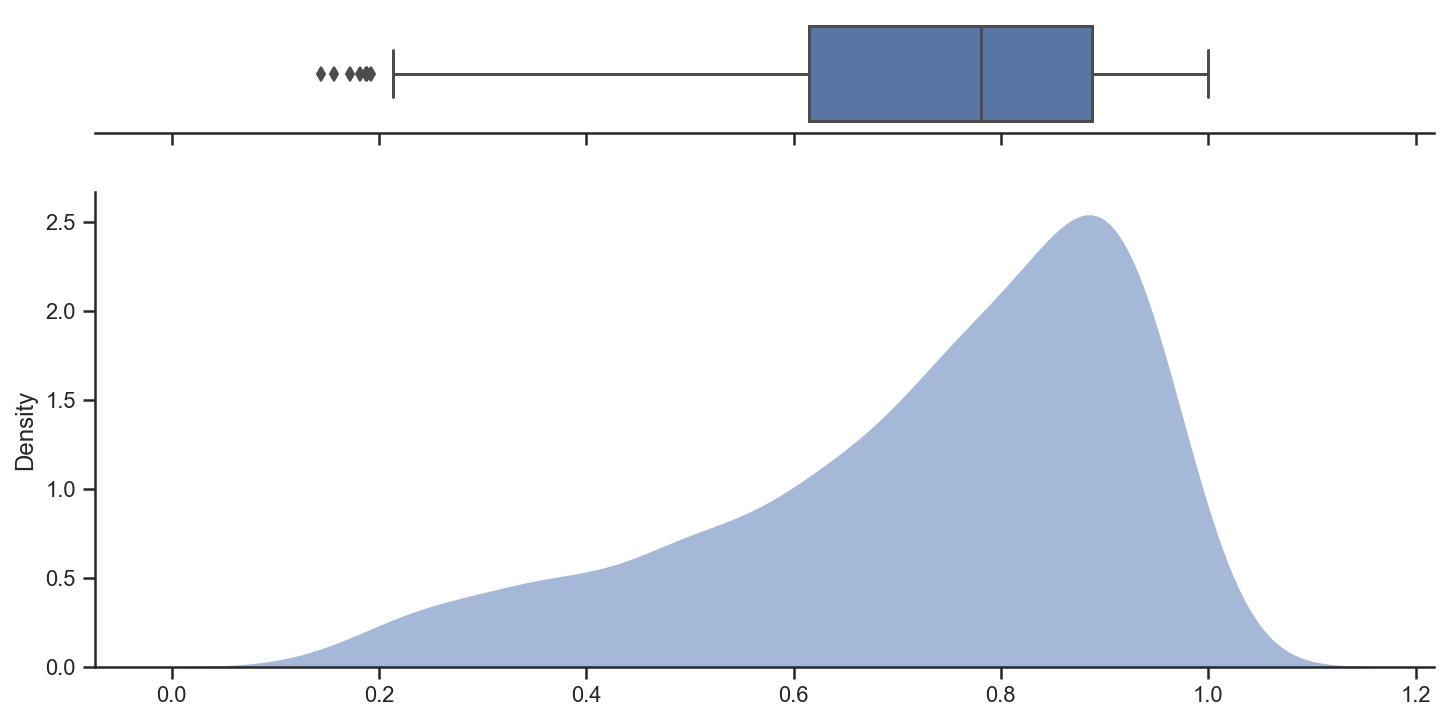

In [34]:
similarities = similarity_df["median_sim"].values

f, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.20, 0.80)}, figsize=(12, 6)
)

sns.boxplot(x=similarities, ax=ax_box)
sns.kdeplot(
    x=similarities,
    ax=ax_hist,
    fill=True,
    common_norm=False,
    palette="crest",
    alpha=0.5,
    linewidth=0,
)

ax_box.set(yticks=[])
ax_hist.set(title=None)

sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

In [35]:
similarity_df["median_sim"].describe().round(2)

count    744.00
mean       0.73
std        0.20
min        0.14
25%        0.61
50%        0.78
75%        0.89
max        1.00
Name: median_sim, dtype: float64

We can see that the title similarity distribution skewed left. And it answers our first question.

### Dissimilar titles

Let's look at titles for which Russian translations doesn't convey meaning of the original name. 

In [36]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(
        similarity_df.iloc[:, :3].sort_values(by="median_sim", ascending=True).iloc[:50]
    )

,russian_title,original_title,median_sim
454,Одинокий волк,Clean,0.144
704,"Человек, который изменил всё",Moneyball,0.157
74,Борат,Borat: Cultural Learnings of America for Make ...,0.172
456,Однажды в Ирландии,The Guard,0.182
665,Философы: Урок выживания,After the Dark,0.188
575,Самый пьяный округ в мире,Lawless,0.189
508,По соображениям совести,Hacksaw Ridge,0.192
267,И грянул шторм,The Finest Hours,0.214
403,Монстры на каникулах,Hotel Transylvania,0.220
97,Ведьма,The VVitch: A New-England Folktale,0.220


There are a few cases for dissimilarity:  

**Russian title is a cropped version of original title**  
Another problem in this case can be the fact that embeddings don't work very well with proper names like Borat::Борат, Dolittle::Дулиттл, and so on.  
Examples:
* Борат::Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan
* Веном 2::Venom: Let There Be Carnage
* Бёрдмэн::Birdman or (The Unexpected Virtue of Ignorance)
* Амели::Le Fabuleux destin d'Amélie Poulain

**Russian title is an extended version of original title**  
(Remark about proper names applies to this case too)  
Examples:
* Удивительное путешествие доктора Дулиттла::Dolittle
* Пол: Секретный материальчик::Paul
* Рапунцель: Запутанная история::Tangled

**Russian title was localized (made up) by translators/localizers**  
Sometimes it is better to localize the title due to cultural and other peculiarities, but sometimes it goes too far.  
Examples:
* Невероятный мир глазами Энцо::The Art of Racing in the Rain
* Человек, который изменил всё::Moneyball
* Области тьмы::Limitless
* Одинокий волк::Clean

And it answers our second question.

### Similar titles

In [37]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(
        similarity_df.iloc[:, :3]
        .sort_values(by="median_sim", ascending=False)
        .iloc[:15]
    )

,russian_title,original_title,median_sim
9,2012,2012,1.000
6,1408,1408,1.000
21,X,X,1.000
12,365 дней,365 dni,0.998
515,Пожары,Incendies,0.985
302,Код 8,Code 8,0.981
379,Мама,Mama,0.980
78,Братья,Brothers,0.977
650,Три метра над уровнем неба,Tres metros sobre el cielo,0.972
539,Преступления будущего,Crimes of the Future,0.971


Similar titles are easier - they are almost literal translation of original titles. 

## Things to do

* Make good visualisations:
    * [Visualizing Embeddings With t-SNE](https://www.kaggle.com/code/colinmorris/visualizing-embeddings-with-t-sne/notebook)
* Add into comparison deleted titles 
For languages, where transcription is used instead of original title (hieroglyphs)
* Add new data (top-1000 series titles)